# Oil & Gas Production Forecasting — ARIMA/SARIMA Model

### 1.Imports and dataset loading

In [5]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import json

sns.set(style="whitegrid")

# Load dataset
df = pd.read_csv("../data/processed/oil_production_features.csv")
df['period'] = pd.to_datetime(df['period'])
df = df.sort_values('period')

# Split the dataset into training and testing sets
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

### 2.Stationarity check 
* ARIMA requires stationarity.
* Oil production data has trend + seasonality → we will use SARIMA which includes seasonal differencing.

### 3.Bayesian hyperparameter tuning using Optuna.

Best practice for ARIMA:
- Tune (p, d, q) for AR
- Tune (P, D, Q, s) for seasonal component
- s = 12 (monthly data → yearly seasonality)

NOTES FROM STATS MODELS:

- autoregressive models: AR(p)
- moving average models: MA(q)
- mixed autoregressive moving average models: ARMA(p, q)
- integration models: ARIMA(p, d, q)
- seasonal models: SARIMA(P, D, Q, s)
- regression with errors that follow one of the above ARIMA-type models

In [6]:
def objective(trial):
    p = trial.suggest_int('p', 0, 5)
    d = trial.suggest_int('d', 0, 2)
    q = trial.suggest_int('q', 0, 5)
    P = trial.suggest_int('P', 0, 2)
    D = trial.suggest_int('D', 0, 1)
    Q = trial.suggest_int('Q', 0, 2)
    s = 12  # fixed seasonality

    try:
        model = SARIMAX(train['MBBL/D'],
                        order=(p, d, q),
                        seasonal_order=(P, D, Q, s),
                        enforce_stationarity=False,
                        enforce_invertibility=False).fit(disp=False)

        pred = model.forecast(steps=len(test))
        return mean_absolute_error(test['MBBL/D'], pred)
    except:
        return np.inf  # handle failed model fits

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2025-05-15 19:39:32,000] A new study created in memory with name: no-name-404aa6f5-d5e5-4e99-956f-fa8b8eb96fda
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2025-05-15 19:39:33,233] Trial 0 finished with value: 1772.859471964886 and parameters: {'p': 4, 'd': 0, 'q': 0, 'P': 1, 'D': 0, 'Q': 1}. Best is trial 0 with value: 1772.859471964886.
c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2025-05-15 19:39:36,383] Trial 1 finished with value: 1655.8202635431192 and parameters: {'p': 4, 'd': 0, 'q': 2, 'P': 2, 'D': 0, 'Q': 1}. Best is trial 1 with value: 1655.8202635431192.
[I 2025-05-15 19:39:36,9

In [7]:
# Best params.
best_params = study.best_params
best_params

{'p': 1, 'd': 2, 'q': 5, 'P': 0, 'D': 1, 'Q': 1}

In [8]:
# Sve the best parameters to a JSON file
with open('../models/arima_best_params.json', 'w') as f:
    json.dump(best_params, f)

###  4. Train final SARIMA model

In [9]:
model = SARIMAX(train['MBBL/D'],
                order=(best_params['p'], best_params['d'], best_params['q']),
                seasonal_order=(best_params['P'], best_params['D'], best_params['Q'], 12),
                enforce_stationarity=False,
                enforce_invertibility=False).fit(disp=False)

pred = model.forecast(steps=len(test))

c:\Users\kmurg\Desktop\Kevin\envs\Enverus\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### 5.Standardized evaluation metrics

In [10]:
y_true = test['MBBL/D'].values
y_pred = pred.values

metrics = {
    "MAE": mean_absolute_error(y_true, y_pred),
    "MSE": mean_squared_error(y_true, y_pred),
    "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
    "R2": r2_score(y_true, y_pred),
    "MAPE": np.mean(np.abs((y_true - y_pred) / y_true)) * 100
}
print(metrics)

{'MAE': 600.15396597737, 'MSE': 560160.3385412937, 'RMSE': np.float64(748.4386003816837), 'R2': 0.6865973472036389, 'MAPE': np.float64(7.361679015711305)}


In [11]:
# Save the model and the results.
results = {"model": "ARIMA", "metrics": metrics}
with open('../results/arima_results.json', 'w') as f:
    json.dump(results, f)

pd.DataFrame({"ds": test['period'], "y_true": y_true, "y_pred": y_pred}).to_csv(
    "../results/arima_predictions.csv", index=False
)

### 6.Plot predictions

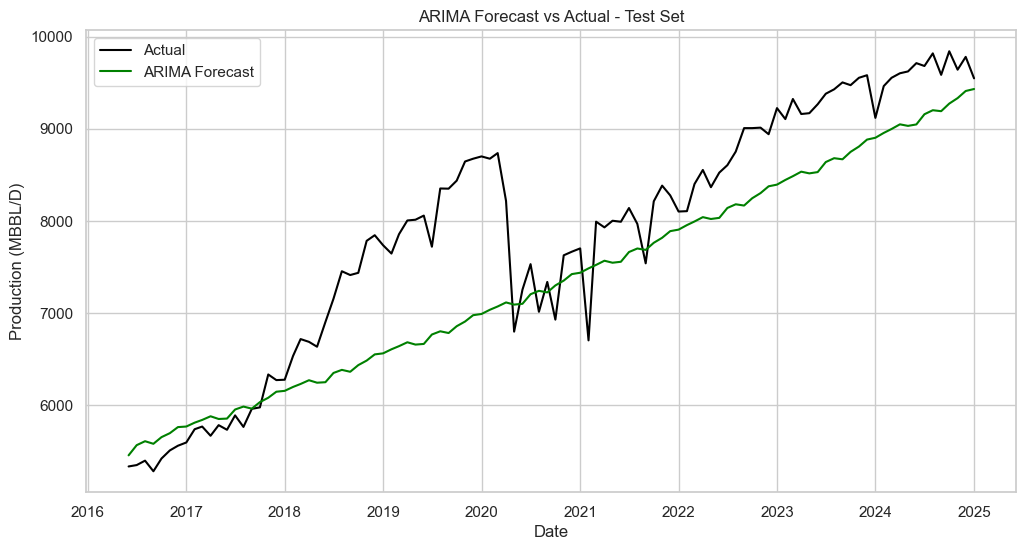

In [12]:
plt.figure(figsize=(12,6))
plt.plot(test['period'], y_true, label='Actual', color='black')
plt.plot(test['period'], y_pred, label='ARIMA Forecast', color='green')
plt.title("ARIMA Forecast vs Actual - Test Set")
plt.xlabel("Date")
plt.ylabel("Production (MBBL/D)")
plt.legend()
plt.show()

We used SARIMA with Bayesian optimization to tune (p,d,q)(P,D,Q,s) hyperparameters.
12-month seasonality was set as oil production often shows yearly cycles.
Evaluation used holdout test set (20%) with same metrics as Prophet for comparability.
Outputs were stored in standardized format for centralized comparison later.